In [ ]:
!pip install optuna
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [ ]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [ ]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [ ]:
# train/validation/test 분리 함수 (시계열 데이터용, 6:2:2 비율)
def split_train_val_test(df):
    n = len(df)

    # 데이터셋 크기 계산
    train_end = int(0.6 * n)
    val_end = int(0.8 * n)  # 0.6 + 0.2

    # 순차적으로 데이터 분할
    train_data = df[:train_end]     # 처음 60%는 train 데이터
    val_data = df[train_end:val_end] # 그 다음 20%는 validation 데이터
    test_data = df[val_end:]        # 마지막 20%는 test 데이터

    # 데이터 크기 출력 (원한다면)
    # print("Train set:", train_data.shape)
    # print("Validation set:", val_data.shape)
    # print("Test set:", test_data.shape)

    return train_data, val_data, test_data

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 성능 테스트 함수

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluation(y_test, y_pred):

    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # MAE (Mean Absolute Error) 계산
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")

    # 예측 결과와 실제 값을 비교하는 샘플 출력
    for i in range(5):  # 예시로 첫 5개만 출력
        print(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")

## 전처리

### 1. 데이터셋 가져오기

In [ ]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [ ]:
df = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lat'])
new_x, lon = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lon'])
new_x, alt = spline_interpolation(df['Timpstemp'] / 1e6 , df[' alt'])

df = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

df = truncation(df)
scaler, df = min_max_scaling(df)

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- GRU를 사용한 모델 클래스 선언
- 구조 : GRU + Fully Connected Layer

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 하이퍼파라미터와 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력만 사용
        return out

In [ ]:
# 모델 학습 함수
def train_model(model, criterion, optimizer, loader, device, history):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    # history가 주어지면 학습 손실 기록
    if history is not None:
        history['train_loss'].append(avg_loss)

    return avg_loss

In [ ]:
# 검증 및 테스트 함수
def evaluate_model(model, criterion, loader, device, history):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []

    start_time = time.time()  # 예측 시작 시간 기록

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            true_values.append(batch_y.cpu().numpy())
            predictions.append(output.cpu().numpy())

    end_time = time.time()  # 예측 종료 시간 기록
    total_inference_time = end_time - start_time

    # print(f"Total Inference Time: {total_inference_time:.2f} seconds")

    avg_loss = total_loss / len(loader)

    # history가 주어지면 검증 손실 기록
    if history is not None:
        history['val_loss'].append(avg_loss)

    return avg_loss, true_values, predictions

In [ ]:
# 데이터 로더 생성 함수
def prepare_dataloader(df, batch_size, look_back=10, forward=0):

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(df)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back, forward)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back, forward)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back, forward)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### 2. 하이퍼파라미터 불러오기

In [ ]:
# import json

# # 1. 저장된 하이퍼파라미터 불러오기
# with open("best_hyperparameters_1014.json", "r") as f:
#     best_params = json.load(f)

# print("Loaded best hyperparameters:", best_params)

## 하이퍼파라미터 탐색

### 1. Optuna 의 objective 함수 선언

+ 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
+ objective 함수 선언

In [ ]:
import optuna
import torch

def objective(trial, df):
    # 탐색할 하이퍼파라미터 값 결정
    n_layers = trial.suggest_int('n_layers', 1, 5)
    n_units_l0 = trial.suggest_int('n_units_l0', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 데이터셋 가져오기
    train_loader, val_loader, test_loader = prepare_dataloader(df, batch_size)

    num_epochs = 300

    # 첫 번째 배치를 가져와 input_size, output_size 계산
    first_batch = next(iter(train_loader))
    X_train_batch, y_train_batch = first_batch
    input_size = X_train_batch.shape[2]  # 입력 데이터의 feature 크기
    output_size = y_train_batch.shape[1]  # 예측할 값의 크기

    # 모델 정의: LSTMModel
    model = GRUModel(input_size, n_units_l0, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    total_val_loss = 0.0  # 모든 epoch에서의 validation loss의 합
    val_loss_count = 0    # 평균을 계산하기 위한 epoch 수

    # 모델 학습
    for epoch in range(num_epochs):

        # Train set으로 학습
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation set에서 성능 측정
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        # 배치 수로 나눠서 평균 validation 손실 계산
        val_loss_avg = val_loss / len(val_loader)

        # Optuna에 중간 값 보고
        trial.report(val_loss_avg, epoch)

        # 총 validation 손실 계산
        total_val_loss += val_loss_avg
        val_loss_count += 1

        # Pruning 조건 확인
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            print(f"Validation Loss at prune: {val_loss_avg:.4f}")  # Prune 시점에서 validation loss 출력

            raise optuna.TrialPruned()

    # 모든 epoch에서의 validation 손실 평균을 반환
    return total_val_loss / val_loss_count

In [ ]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(lambda trial: objective(trial, df), n_trials=100)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-20 05:08:42,146] A new study created in memory with name: no-name-7bebe3cb-0a2c-485b-8a0a-d349e8682b48
[I 2024-10-20 05:10:13,429] Trial 0 finished with value: 0.003829120676924295 and parameters: {'n_layers': 2, 'n_units_l0': 110, 'learning_rate': 2.119652539973029e-05, 'batch_size': 39}. Best is trial 0 with value: 0.003829120676924295.
[I 2024-10-20 05:12:34,882] Trial 1 finished with value: 0.0006048006708559702 and parameters: {'n_layers': 5, 'n_units_l0': 176, 'learning_rate': 0.0001540607306272521, 'batch_size': 69}. Best is trial 1 with value: 0.0006048006708559702.
[I 2024-10-20 05:13:18,033] Trial 2 finished with value: 0.00042284771939731376 and parameters: {'n_layers': 4, 'n_units_l0': 71, 'learning_rate': 0.001063871836123269, 'batch_size': 106}. Best is trial 2 with value: 0.00042284771939731376.
[I 2024-10-20 05:13:45,409] Trial 3 finished with value: 0.0024580038648006545 and parameters: {'n_layers': 1, 'n_units_l0': 59, 'learning_rate': 0.0002952509027535862

Trial 5 pruned at epoch 10
Validation Loss at prune: 0.0968


[I 2024-10-20 05:14:30,682] Trial 6 pruned. 


Trial 6 pruned at epoch 10
Validation Loss at prune: 0.0590


[I 2024-10-20 05:14:33,103] Trial 7 pruned. 


Trial 7 pruned at epoch 17
Validation Loss at prune: 0.0027


[I 2024-10-20 05:15:30,906] Trial 8 finished with value: 0.0016313851436053452 and parameters: {'n_layers': 2, 'n_units_l0': 151, 'learning_rate': 5.772574684138437e-05, 'batch_size': 66}. Best is trial 2 with value: 0.00042284771939731376.
[I 2024-10-20 05:15:33,044] Trial 9 pruned. 


Trial 9 pruned at epoch 10
Validation Loss at prune: 0.0081


[I 2024-10-20 05:17:28,176] Trial 10 pruned. 


Trial 10 pruned at epoch 162
Validation Loss at prune: 0.0022


[I 2024-10-20 05:18:46,884] Trial 11 finished with value: 0.00020123195029836583 and parameters: {'n_layers': 5, 'n_units_l0': 209, 'learning_rate': 0.000971951024631951, 'batch_size': 80}. Best is trial 11 with value: 0.00020123195029836583.
[I 2024-10-20 05:19:51,705] Trial 12 finished with value: 0.0001340451507631871 and parameters: {'n_layers': 4, 'n_units_l0': 225, 'learning_rate': 0.0013983442012592449, 'batch_size': 90}. Best is trial 12 with value: 0.0001340451507631871.
[I 2024-10-20 05:21:12,584] Trial 13 finished with value: 0.00021396668083980335 and parameters: {'n_layers': 5, 'n_units_l0': 253, 'learning_rate': 0.0015462147925000965, 'batch_size': 90}. Best is trial 12 with value: 0.0001340451507631871.
[I 2024-10-20 05:21:16,577] Trial 14 pruned. 


Trial 14 pruned at epoch 10
Validation Loss at prune: 0.0145


[I 2024-10-20 05:22:17,924] Trial 15 finished with value: 0.0001203855377894754 and parameters: {'n_layers': 3, 'n_units_l0': 201, 'learning_rate': 0.0006558443861083619, 'batch_size': 79}. Best is trial 15 with value: 0.0001203855377894754.
[I 2024-10-20 05:24:01,966] Trial 16 finished with value: 0.0001051294797396924 and parameters: {'n_layers': 3, 'n_units_l0': 183, 'learning_rate': 0.0005250005786888636, 'batch_size': 54}. Best is trial 16 with value: 0.0001051294797396924.
[I 2024-10-20 05:25:48,354] Trial 17 finished with value: 9.34197665342977e-05 and parameters: {'n_layers': 3, 'n_units_l0': 184, 'learning_rate': 0.00045803773328119033, 'batch_size': 51}. Best is trial 17 with value: 9.34197665342977e-05.
[I 2024-10-20 05:27:37,963] Trial 18 finished with value: 0.00027103429165928604 and parameters: {'n_layers': 3, 'n_units_l0': 173, 'learning_rate': 0.00020416082924959022, 'batch_size': 46}. Best is trial 17 with value: 9.34197665342977e-05.
[I 2024-10-20 05:27:40,021] Tria

Trial 19 pruned at epoch 10
Validation Loss at prune: 0.0005


[I 2024-10-20 05:30:18,480] Trial 20 finished with value: 0.00013325102315351367 and parameters: {'n_layers': 3, 'n_units_l0': 176, 'learning_rate': 0.0001302640548713225, 'batch_size': 26}. Best is trial 17 with value: 9.34197665342977e-05.
[I 2024-10-20 05:31:37,193] Trial 21 finished with value: 0.00010118349551527916 and parameters: {'n_layers': 3, 'n_units_l0': 196, 'learning_rate': 0.0005598356630160279, 'batch_size': 58}. Best is trial 17 with value: 9.34197665342977e-05.
[I 2024-10-20 05:33:46,592] Trial 22 finished with value: 5.910509841939415e-05 and parameters: {'n_layers': 3, 'n_units_l0': 190, 'learning_rate': 0.00035715137269119474, 'batch_size': 34}. Best is trial 22 with value: 5.910509841939415e-05.
[I 2024-10-20 05:36:00,761] Trial 23 finished with value: 0.00023581530295633017 and parameters: {'n_layers': 3, 'n_units_l0': 193, 'learning_rate': 0.002961715899854957, 'batch_size': 33}. Best is trial 22 with value: 5.910509841939415e-05.
[I 2024-10-20 05:37:06,736] Tri

Trial 28 pruned at epoch 10
Validation Loss at prune: 0.0007


[I 2024-10-20 05:43:59,928] Trial 29 finished with value: 0.005165644860563687 and parameters: {'n_layers': 2, 'n_units_l0': 164, 'learning_rate': 0.008186644522638798, 'batch_size': 43}. Best is trial 27 with value: 5.4852004963474126e-05.
[I 2024-10-20 05:44:04,282] Trial 30 pruned. 


Trial 30 pruned at epoch 10
Validation Loss at prune: 0.0207


[I 2024-10-20 05:45:52,860] Trial 31 finished with value: 0.00010612597368114822 and parameters: {'n_layers': 3, 'n_units_l0': 138, 'learning_rate': 0.002612683555915657, 'batch_size': 36}. Best is trial 27 with value: 5.4852004963474126e-05.
[I 2024-10-20 05:47:14,377] Trial 32 finished with value: 4.825602626696327e-05 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'learning_rate': 0.0022385233135800023, 'batch_size': 38}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 05:47:16,885] Trial 33 pruned. 


Trial 33 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-20 05:49:07,105] Trial 34 finished with value: 5.235833062237322e-05 and parameters: {'n_layers': 2, 'n_units_l0': 86, 'learning_rate': 0.0015830835008200938, 'batch_size': 27}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 05:50:56,949] Trial 35 finished with value: 6.531670947012457e-05 and parameters: {'n_layers': 2, 'n_units_l0': 95, 'learning_rate': 0.0015902375387949349, 'batch_size': 27}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 05:52:13,836] Trial 36 finished with value: 0.00015064772600843746 and parameters: {'n_layers': 2, 'n_units_l0': 79, 'learning_rate': 0.005773855286865549, 'batch_size': 40}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 05:54:07,609] Trial 37 finished with value: 5.288750117099163e-05 and parameters: {'n_layers': 1, 'n_units_l0': 73, 'learning_rate': 0.0018686536556734485, 'batch_size': 22}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 05:56:23,206] Trial 38

Trial 43 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:06:05,882] Trial 44 finished with value: 4.94732419082311e-05 and parameters: {'n_layers': 1, 'n_units_l0': 46, 'learning_rate': 0.0018082213844531282, 'batch_size': 21}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 06:07:58,388] Trial 45 finished with value: 6.540856363553112e-05 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'learning_rate': 0.004543755103122552, 'batch_size': 22}. Best is trial 32 with value: 4.825602626696327e-05.
[I 2024-10-20 06:08:01,612] Trial 46 pruned. 


Trial 46 pruned at epoch 10
Validation Loss at prune: 0.0003


[I 2024-10-20 06:09:54,463] Trial 47 finished with value: 4.806554049121148e-05 and parameters: {'n_layers': 1, 'n_units_l0': 61, 'learning_rate': 0.0012748213525495744, 'batch_size': 22}. Best is trial 47 with value: 4.806554049121148e-05.
[I 2024-10-20 06:09:56,425] Trial 48 pruned. 


Trial 48 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:09:58,057] Trial 49 pruned. 


Trial 49 pruned at epoch 11
Validation Loss at prune: 0.0001


[I 2024-10-20 06:12:28,770] Trial 50 finished with value: 0.0001717443257127107 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'learning_rate': 0.006302800148282225, 'batch_size': 16}. Best is trial 47 with value: 4.806554049121148e-05.
[I 2024-10-20 06:12:33,797] Trial 51 pruned. 


Trial 51 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-20 06:14:27,026] Trial 52 finished with value: 4.369552917939138e-05 and parameters: {'n_layers': 1, 'n_units_l0': 65, 'learning_rate': 0.001884397730379044, 'batch_size': 22}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:15:54,944] Trial 53 finished with value: 5.18170776118254e-05 and parameters: {'n_layers': 1, 'n_units_l0': 106, 'learning_rate': 0.0011211788307223152, 'batch_size': 29}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:17:20,105] Trial 54 finished with value: 5.807025552025349e-05 and parameters: {'n_layers': 1, 'n_units_l0': 110, 'learning_rate': 0.0011140525213611395, 'batch_size': 30}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:18:31,412] Trial 55 finished with value: 6.615802054823735e-05 and parameters: {'n_layers': 1, 'n_units_l0': 43, 'learning_rate': 0.002486433219905357, 'batch_size': 37}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:18:33,779] Trial 56 

Trial 56 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-20 06:18:38,288] Trial 57 pruned. 


Trial 57 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-20 06:20:41,491] Trial 58 finished with value: 8.754972495890141e-05 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'learning_rate': 0.0037386338735080253, 'batch_size': 20}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:20:45,319] Trial 59 pruned. 


Trial 59 pruned at epoch 10
Validation Loss at prune: 0.0008


[I 2024-10-20 06:20:48,379] Trial 60 pruned. 


Trial 60 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:22:51,255] Trial 61 finished with value: 6.389072346401347e-05 and parameters: {'n_layers': 2, 'n_units_l0': 86, 'learning_rate': 0.001675195825745886, 'batch_size': 24}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:24:14,120] Trial 62 finished with value: 4.666638721557273e-05 and parameters: {'n_layers': 2, 'n_units_l0': 100, 'learning_rate': 0.0013243230602069563, 'batch_size': 37}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:25:17,122] Trial 63 finished with value: 6.1001272847361676e-05 and parameters: {'n_layers': 2, 'n_units_l0': 102, 'learning_rate': 0.0012919542834381342, 'batch_size': 51}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:25:22,409] Trial 64 pruned. 


Trial 64 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:26:32,189] Trial 65 finished with value: 4.681931525049604e-05 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'learning_rate': 0.002223234063853008, 'batch_size': 37}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:26:36,435] Trial 66 pruned. 


Trial 66 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:26:39,818] Trial 67 pruned. 


Trial 67 pruned at epoch 10
Validation Loss at prune: 0.0039


[I 2024-10-20 06:27:52,710] Trial 68 finished with value: 5.128503364240565e-05 and parameters: {'n_layers': 1, 'n_units_l0': 125, 'learning_rate': 0.003127545891781332, 'batch_size': 36}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:28:47,704] Trial 69 finished with value: 4.526732541423277e-05 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'learning_rate': 0.0032059933083048247, 'batch_size': 50}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:29:37,555] Trial 70 finished with value: 7.798619330682887e-05 and parameters: {'n_layers': 2, 'n_units_l0': 145, 'learning_rate': 0.00431002935051561, 'batch_size': 77}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:30:24,185] Trial 71 finished with value: 7.266325005284001e-05 and parameters: {'n_layers': 1, 'n_units_l0': 122, 'learning_rate': 0.0069962912035169515, 'batch_size': 62}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:31:21,444] Trial 7

Trial 75 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:34:47,277] Trial 76 finished with value: 0.00011436853642692317 and parameters: {'n_layers': 2, 'n_units_l0': 122, 'learning_rate': 0.003666778444180251, 'batch_size': 46}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:34:49,286] Trial 77 pruned. 


Trial 77 pruned at epoch 10
Validation Loss at prune: 0.0002


[I 2024-10-20 06:36:09,569] Trial 78 finished with value: 5.400946923787823e-05 and parameters: {'n_layers': 1, 'n_units_l0': 135, 'learning_rate': 0.0024291238272138214, 'batch_size': 34}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:37:16,477] Trial 79 finished with value: 6.201439476306334e-05 and parameters: {'n_layers': 2, 'n_units_l0': 148, 'learning_rate': 0.001847670467238407, 'batch_size': 56}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:37:21,237] Trial 80 pruned. 


Trial 80 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-20 06:37:24,638] Trial 81 pruned. 


Trial 81 pruned at epoch 10
Validation Loss at prune: 0.0001


[I 2024-10-20 06:37:27,818] Trial 82 pruned. 


Trial 82 pruned at epoch 11
Validation Loss at prune: 0.0001


[I 2024-10-20 06:37:31,237] Trial 83 pruned. 


Trial 83 pruned at epoch 10
Validation Loss at prune: 0.0004


[I 2024-10-20 06:38:52,882] Trial 84 finished with value: 5.2266716220509845e-05 and parameters: {'n_layers': 1, 'n_units_l0': 118, 'learning_rate': 0.003249493821712844, 'batch_size': 31}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:40:26,229] Trial 85 finished with value: 0.00013580104718292316 and parameters: {'n_layers': 1, 'n_units_l0': 98, 'learning_rate': 0.005199009668238104, 'batch_size': 27}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:41:35,315] Trial 86 finished with value: 7.930793676750025e-05 and parameters: {'n_layers': 1, 'n_units_l0': 67, 'learning_rate': 0.009698012235646048, 'batch_size': 38}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:41:37,731] Trial 87 pruned. 


Trial 87 pruned at epoch 10
Validation Loss at prune: 0.0003


[I 2024-10-20 06:43:21,465] Trial 88 finished with value: 5.040738349010066e-05 and parameters: {'n_layers': 1, 'n_units_l0': 107, 'learning_rate': 0.0019968917736416496, 'batch_size': 24}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:45:35,183] Trial 89 finished with value: 5.4018400510897264e-05 and parameters: {'n_layers': 2, 'n_units_l0': 133, 'learning_rate': 0.0019750912900028707, 'batch_size': 24}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:47:42,047] Trial 90 finished with value: 6.241073568967507e-05 and parameters: {'n_layers': 1, 'n_units_l0': 39, 'learning_rate': 0.0030641869315312623, 'batch_size': 19}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:49:11,827] Trial 91 finished with value: 5.0907340295983306e-05 and parameters: {'n_layers': 1, 'n_units_l0': 106, 'learning_rate': 0.0022560355778197027, 'batch_size': 28}. Best is trial 52 with value: 4.369552917939138e-05.
[I 2024-10-20 06:51:12,012] Tri

Best hyperparameters:  {'n_layers': 1, 'n_units_l0': 117, 'learning_rate': 0.0024064401794910207, 'batch_size': 26}


### 2. 하이퍼파라미터 저장

In [ ]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters_1014.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


### 3. 하이퍼파라미터 불러오기

In [ ]:
import json

# 1. 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters_1014.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'n_layers': 1, 'n_units_l0': 117, 'learning_rate': 0.0024064401794910207, 'batch_size': 26}


## 학습

1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader에 load

### 1. 최적의 파라미터로 모델 학습

In [ ]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = prepare_dataloader(df, best_params['batch_size'])

best_model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

In [ ]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수
history = {'train_loss': [], 'val_loss': []}

num_epochs = 300
for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # history가 주어지면 학습 손실 기록
    history['train_loss'].append(train_loss / len(train_loader))

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()


    # history가 주어지면 학습 손실 기록
    history['val_loss'].append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 50 == 0:
      model_save_path = f"/content/gru/best_model_epoch_{epoch+1}.pth"
      torch.save({
        'model_state_dict': best_model.state_dict(),
        'train_losses': history['train_loss'],
        'val_losses': history['val_loss']
      }, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")



Epoch [1/300], Train Loss: 1.4978, Val Loss: 0.0507
Epoch 1/300 completed in 2.19 seconds.
Epoch [2/300], Train Loss: 0.0221, Val Loss: 0.0058
Epoch 2/300 completed in 0.79 seconds.
Epoch [3/300], Train Loss: 0.0138, Val Loss: 0.0038
Epoch 3/300 completed in 1.03 seconds.
Epoch [4/300], Train Loss: 0.0110, Val Loss: 0.0040
Epoch 4/300 completed in 0.62 seconds.
Epoch [5/300], Train Loss: 0.0100, Val Loss: 0.0026
Epoch 5/300 completed in 0.45 seconds.
Epoch [6/300], Train Loss: 0.0074, Val Loss: 0.0022
Epoch 6/300 completed in 0.58 seconds.
Epoch [7/300], Train Loss: 0.0074, Val Loss: 0.0022
Epoch 7/300 completed in 0.42 seconds.
Epoch [8/300], Train Loss: 0.0068, Val Loss: 0.0022
Epoch 8/300 completed in 0.50 seconds.
Epoch [9/300], Train Loss: 0.0051, Val Loss: 0.0021
Epoch 9/300 completed in 0.48 seconds.
Epoch [10/300], Train Loss: 0.0057, Val Loss: 0.0027
Epoch 10/300 completed in 0.56 seconds.
Epoch [11/300], Train Loss: 0.0046, Val Loss: 0.0024
Epoch 11/300 completed in 0.42 seco

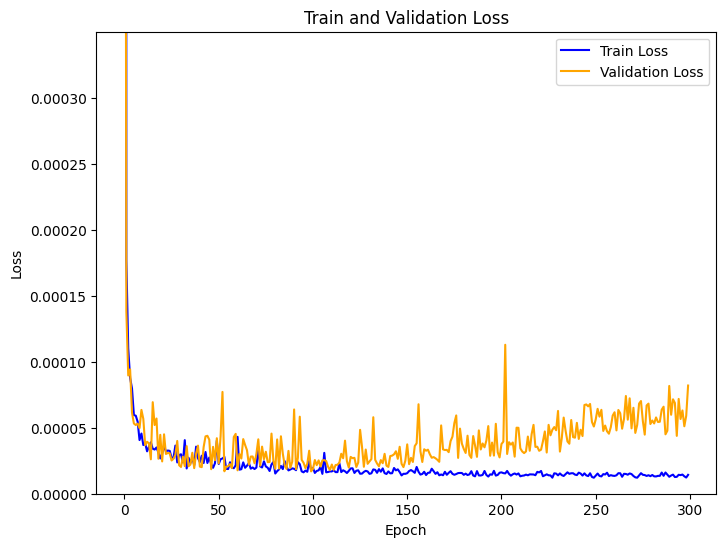

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 후 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# y축 범위 설정
plt.ylim(0, 0.00035)

# y축 눈금 설정 (0.0003까지 표시)
plt.yticks(np.arange(0, 0.00031, 0.00005))

# 격자 없애기
plt.grid(False)

plt.legend()
plt.show()

In [ ]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 117]              42,822
├─Linear: 1-2                            [1, 3]                    354
Total params: 43,176
Trainable params: 43,176
Non-trainable params: 0
Total mult-adds (M): 0.43
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.17
Estimated Total Size (MB): 0.18

## 테스트

### 1. 테스트 결과 생성

#### .pth 에서 불러와서 사용할 때

In [ ]:
# # 모델 초기화 (저장할 때 사용한 것과 동일한 구조로)
# model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])

# # GPU 사용 가능 시 모델을 GPU로 이동
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # 저장된 모델 가중치 불러오기
# model.load_state_dict(torch.load("/content/drive/MyDrive/deep-uav/1014_lookback10_forward0/best_model_1014_epoch_300.pth", map_location=device)["model_state_dict"])

# # 평가 모드로 전환 (dropout 등을 비활성화)
# model.eval()

In [ ]:
train_loader, val_loader, test_loader = prepare_dataloader(df, 17, 10)
criterion = torch.nn.MSELoss()

#### pth 말고 학습하고 바로 사용할 때

In [ ]:
model = best_model

In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import time

# 모델 예측 및 성능 평가
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []
total_correct = 0
total_samples = 0

threshold = 0.01  # Accuracy를 계산할 때 사용할 임계값 (오차 허용 범위)

start_time = time.time()  # 예측 시작 시간 기록

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

        # Accuracy 계산 (오차가 threshold 이하인 경우 correct로 간주)
        y_pred_cpu = output.cpu().numpy()
        y_true_cpu = batch_y.cpu().numpy()
        correct = np.sum(np.linalg.norm(y_pred_cpu - y_true_cpu, axis=1) < threshold)
        total_correct += correct
        total_samples += len(batch_y)

end_time = time.time()  # 예측 종료 시간 기록

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
accuracy = total_correct / total_samples

# 예측 시간 계산
prediction_time = end_time - start_time

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Total Prediction Time: {prediction_time:.4f} seconds')

Mean Squared Error (MSE): 1.264993170480011e-05
Mean Absolute Error (MAE): 0.002135021612048149
Accuracy: 94.70%
Total Prediction Time: 0.0596 seconds


### 2. 결과 시각화

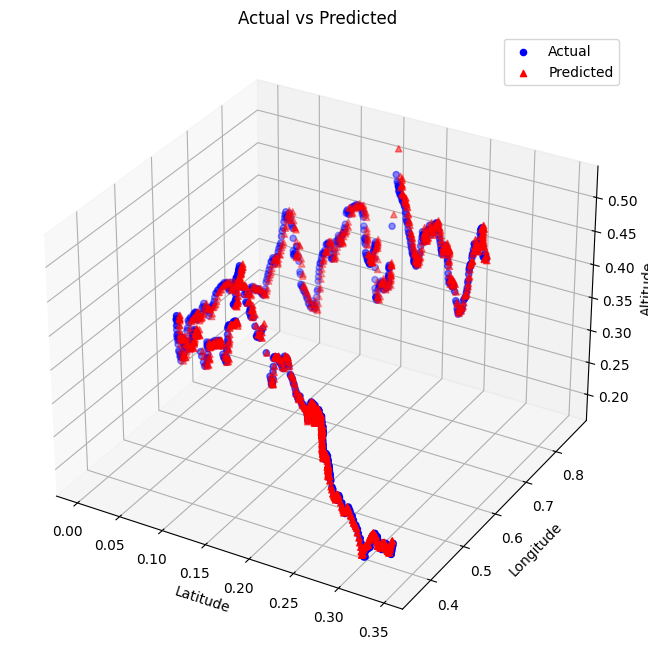

In [ ]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

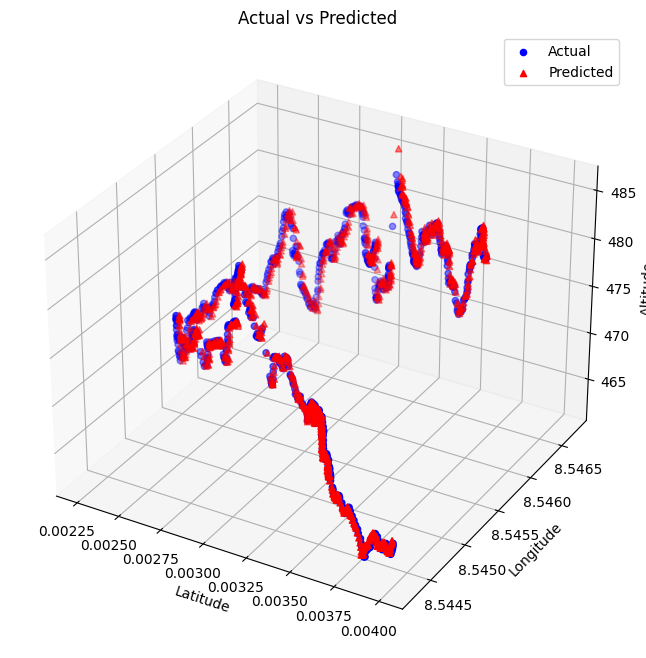

In [ ]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

## 다른 모델이랑 비교

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison(df, num_epochs, y_limits=None):

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    # colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    colors = ['#1f77b4', '#ff7f0e']


    sns.set(style="whitegrid")

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot Train Loss
    axs[0].plot(df['epoch'], df['train_loss_1'], label='lstm', color=colors[0], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_2'], label='gru', color=colors[1], marker='o', markevery=[-1])
    # axs[0].plot(df['epoch'], df['train_loss_3'], label='transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0].set_title('Train Loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(range(30, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0].legend()
    axs[0].yaxis.grid(False)  # 가로줄 끄기
    axs[0].xaxis.grid(False)  # 세로줄 끄기

    # # Y축을 로그 스케일로 설정
    # axs[0].set_yscale('log')

    axs[0].ticklabel_format(style='plain', axis='y')

    # Y축 수동 설정
    if y_limits:
        axs[0].set_ylim(y_limits[0], y_limits[1])

    # Plot Valid Loss
    axs[1].plot(df['epoch'], df['valid_loss_1'], label='lstm', color=colors[0], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_2'], label='gru', color=colors[1], marker='o', markevery=[-1])
    # axs[1].plot(df['epoch'], df['valid_loss_3'], label='transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1].set_title('Valid Loss')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(range(30, num_epochs + 1, xticks_interval))
    axs[1].legend()
    axs[1].yaxis.grid(False)  # 가로줄 끄기
    axs[1].xaxis.grid(False)  # 세로줄 끄기

    # # Y축을 로그 스케일로 설정
    # axs[1].set_yscale('log')

    # Y축 수동 설정
    if y_limits:
        axs[1].set_ylim(y_limits[0], y_limits[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [ ]:
checkpoint = torch.load('/content/best_model_epoch_300.pth')
print(checkpoint.keys())

lstm_train_losses = checkpoint['train_losses'][30:]
lstm_val_losses = checkpoint['val_losses'][30:]

checkpoint = torch.load('/content/gru/best_model_epoch_300.pth')
print(checkpoint.keys())

gru_train_losses = checkpoint['train_losses'][30:]
gru_val_losses = checkpoint['val_losses'][30:]


# checkpoint = torch.load('/content/transformer_300.pth')
# print(checkpoint.keys())

# transformer_train_losses = checkpoint['train_losses'][30:]
# transformer_val_losses = checkpoint['val_losses'][30:]



dict_keys(['model_state_dict', 'train_losses', 'val_losses'])
dict_keys(['model_state_dict', 'train_losses', 'val_losses'])


<ipython-input-36-c97740a989cb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/best_model_epoch_300.pth')
<ipython-input-36-c97740a989cb>

In [ ]:
data = {
    'epoch': list(range(1, 270 + 1)),  # 실제 에포크 수만큼
    'train_loss_1': lstm_train_losses,
    'train_loss_2': gru_train_losses,
    # 'train_loss_3': transformer_train_losses,
    'valid_loss_1': lstm_val_losses,
    'valid_loss_2': gru_val_losses,
    # 'valid_loss_3': transformer_val_losses
}

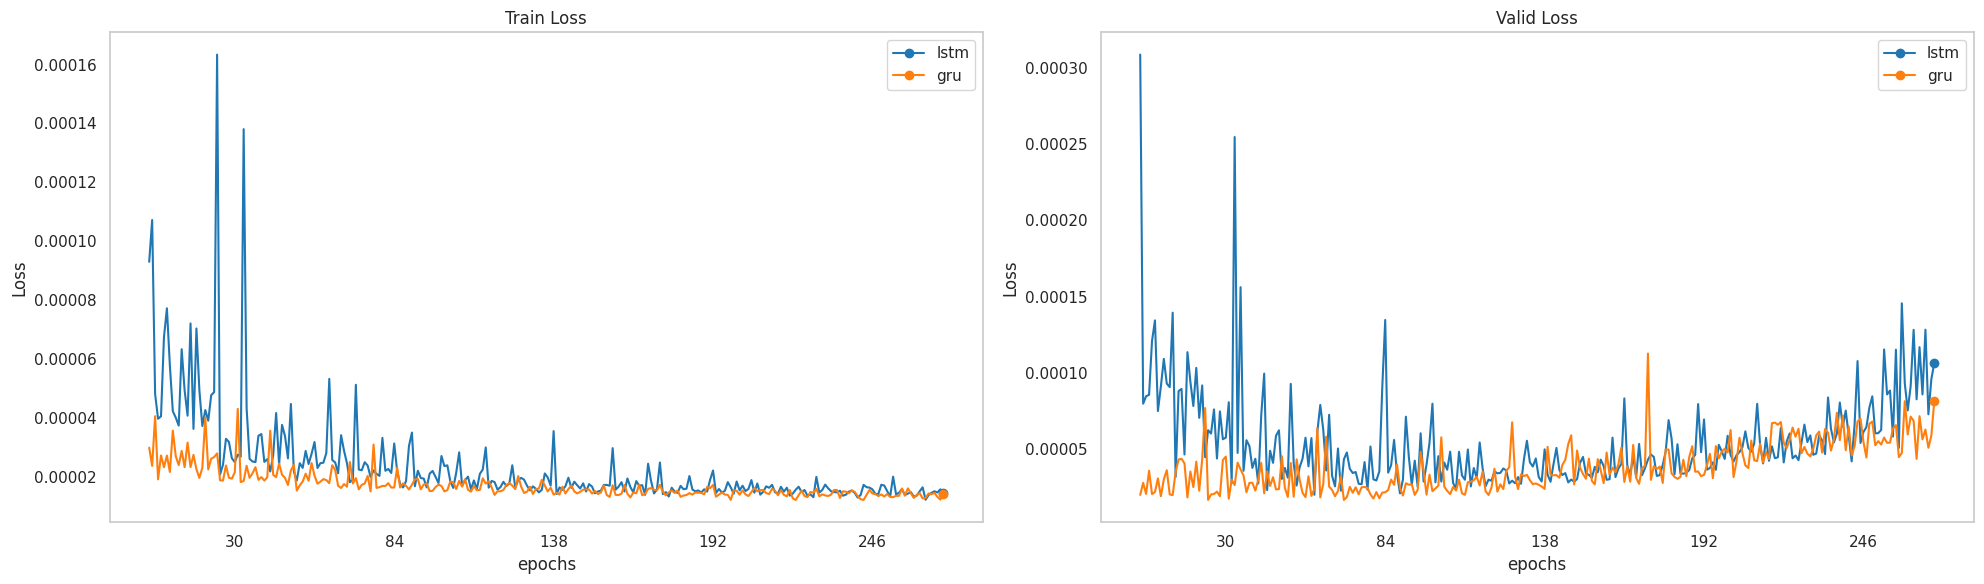

In [ ]:
df = pd.DataFrame(data)

# 그래프 그리기
plot_model_comparison(df, 270)